In [1]:
import numpy as np
import matplotlib.pyplot as plt
from qutip import *
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

# Ramsey Experiment
To simulate Ramsey experiments for measuring atom frequency, we'll outline a basic framework that captures the essence of such experiments. Ramsey's method of separated oscillatory fields is widely used in precision measurements, including atomic clocks. The experiment involves two key stages: interaction of atoms with two separated oscillating fields and measuring the resulting interference pattern to determine the frequency of the atoms.

Here's a simplified model of the process:
1. **Preparation of the Atomic System:** We prepare a system of atoms in a superposition state using a $\pi/2$ pulse, which puts the atoms into a state that is an equal superposition of two energy levels.
2. **Free Evolution:** The atoms evolve freely for a time $T$, during which the phase between the two energy levels accumulates due to the difference between the actual atomic transition frequency ($\omega_0$) and the applied field frequency ($\omega$).
3. **Second $\pi/2$ Pulse and Detection:** After the free evolution, another π/2 pulse is applied, leading to interference between the states, which depends on the accumulated phase. The probability of finding an atom in a certain state is measured, which shows an oscillatory dependence on the phase difference, thus on the frequency difference.
4. **Measurement:** By varying the time $T$ or the frequency $\omega$ of the applied field, we can measure the oscillations in the final state populations, which allows us to determine the atomic transition frequency with high precision.

In [2]:
# Define the Hamiltonian
def Hamiltonian(delta, rabi, phase):
    """
    Calculates the Hamiltonian for a quantum system.

    Parameters:
    delta (float): The detuning of the qubit frequency and the light field frequency.
    rabi (float): The Rabi frequency.
    phase (float): The light phase factor.

    Returns:
    numpy.ndarray: The Hamiltonian matrix.
    """
    return 0.5 * (delta) * sigmaz() + 0.5 * rabi * (sigmap() * np.exp(-1j*phase) + sigmam() * np.exp(1j*phase))


# Define free evolution Hamiltonian
def freeHamiltonian(delta):
    """
    Calculates the free Hamiltonian for a quantum system.
    
    Parameters:
        delta (float): The detuning of the qubit frequency and the light field frequency.
    
    Returns:
        float: The calculated free Hamiltonian value.
    """
    return 0.5 * delta * sigmaz()

1. Preparation of the Atomic System

In [3]:
# The first step of the quantum evolution
def firstStep(delta, rabi, time):
    """
    Calculates the pi/2 pulse duration and the state after the duration.

    Parameters:
    delta (float): The detuning of the qubit frequency and the light field frequency.
    rabi (float): The Rabi frequency.
    time (float): The duration of the evolution.
    
    Returns:
    qutip.qobj.Qobj: The final state after the evolution.
    """
    # Define the initial state and the evolution time
    initial_state = basis(2, 1)  # The initial state |g⟩
    evolution_time = np.linspace(0, time, 10000)

    # Evolve the system
    results = mesolve(Hamiltonian(delta, rabi, 0), initial_state, evolution_time, [], [])

    # Calculate the probability of the state |e⟩ and |g⟩ after evolution
    prob_e = [abs(state[0][0][0])**2 for state in results.states]  # |⟨e|ψ⟩|^2

    # Solve the duration time for pi/2-pulse
    # Find the time at which prob_e is closest to 0.5
    crossing_indices = np.where(np.diff(np.sign(np.array(prob_e) - 0.5)))[0]
    if len(crossing_indices) > 0:
        duration = evolution_time[crossing_indices[0]]  # pi/2-pulse duration
        final_state = results.states[crossing_indices[0]]  # The state after the pi/2-pulse

        return final_state, duration
    
    else:
        return None, None


2. Free evolution

In [4]:
# The second step of the quantum evolution
def secondStep(delta, initial_state, time):
    """
    The second step of the quantum evolution.

    Parameters:
    delta (float): The detuning of the qubit frequency and the light field frequency.
    states (list): The states after the first step of the evolution.

    Returns:
    list: The states after the second step of the evolution.
    """
    # Evolve the system under free Hamiltonian
    final_state = (-1j * freeHamiltonian(delta) * time).expm() * initial_state
    
    return final_state # The state after the free evolution

3. Second $\pi/2$ Pulse and Detection

In [5]:
# The third step of the quantum evolution
def thirdStep(delta, rabi, phase, initial_state, time):
    """
    The third step of the quantum evolution. 

    Parameters:
    delta (float): The detuning of the qubit frequency and the light field frequency.
    rabi (float): The Rabi frequency.
    phase (float): The light phase factor.
    initial_state (list): The states after the second step of the evolution.
    duration (float): The duration of the pi/2-pulse.

    Returns:
    float: The probability of the state |e⟩ after the third step of the evolution.
    """
    # Evolve the system under the Hamiltonian with the phase factor
    final_state = (-1j * Hamiltonian(delta, rabi, phase) * time).expm() * initial_state

    return abs(final_state[0][0][0])**2


## Main

In [6]:
# Parameters
rabi = 2 * np.pi * 0.1  # Rabi frequency 
phase = 0  # Phase of the light field
# phase = np.random.uniform(0, 2*np.pi) 
delta = np.linspace(-0.8, 0.8, 21) * rabi  # Detuning
evolution_time = 5.0 # Evolution time range
free_evolution_time = 2.0 # Free evolution time

# Calculate the probability of the state |e⟩ after the whole evolution
prob_e = []
for delta_value in delta:
    state1, duration = firstStep(delta_value, rabi, evolution_time)
    state2 = secondStep(delta_value, state1, free_evolution_time)
    prob_e.append(thirdStep(delta_value, rabi, phase, state2, duration))



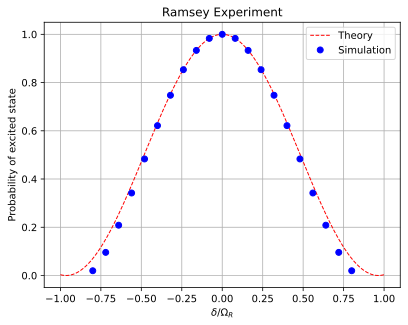

In [7]:
# Plot the results
x = np.linspace(-1, 1, 1000)
plt.plot(x, (np.cos(x + x*rabi*free_evolution_time/2 - phase/2))**2, '--r', linewidth=1) # Theory
plt.plot(delta/rabi, prob_e, 'ob') # Simulation
plt.xlabel('$\delta/\Omega_R$')
plt.ylabel('Probability of excited state')
plt.title('Ramsey Experiment')
plt.legend(['Theory','Simulation'])
plt.grid()
plt.show()